# Project: Identify Customer Segments

In this project, I apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that will be used has been provided by Udacity's partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

At the end of most sections, there is a Markdown cell labeled **Discussion**. In these cells, are reported my findings for the completed section, as well as the decisions that were made. 

In [1]:
# import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic function producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, we load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. 

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

#Check that data were properly loaded
if azdias.shape[0] == 891221 and azdias.shape[1] == 85:
    print("Success: azdias file loaded correctly")
else:
    print("Warrning: shape for azdias file does not correspond to the info in task description")
    
if feat_info.shape[0] == 85 and feat_info.shape[1] == 4:
    print("Success: feat_info file loaded correctly")
else:
    print("Warrning: shape for feat_info file does not correspond to the info in task description")

Success: azdias file loaded correctly
Success: feat_info file loaded correctly


In [3]:
# Check the structure of the general demographics data
print ("\nAzdias data structure:")
print(azdias.shape)


Azdias data structure:
(891221, 85)


In [4]:
# Check the structure of the feature summary data

print ("\nfeat_info data structure:")
print(feat_info.shape)
print(feat_info.head(5))


feat_info data structure:
(85, 4)
              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help in making cleaning decisions during this stage of the project. First of all, we should assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We need to do a little bit of parsing to make use of it to identify and clean the data. Below we convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 

In [5]:
# Display data format
test = feat_info.loc[:,"missing_or_unknown"]
print(test.head(7))

0      [-1,0]
1    [-1,0,9]
2      [-1,0]
3         [0]
4        [-1]
5        [-1]
6        [-1]
Name: missing_or_unknown, dtype: object


In [6]:
#Extract values from string 
# before: feat_info['missing_or_unknown'] = '[-1, 0]' (string)
# after: missing_vals['nan_vals'] = [-1, 0] (field)

def is_int(value):
    try:
        int(value)
        return True
    except ValueError:
        return False

data_dict = {'nan_vals': feat_info['missing_or_unknown'] \
             .str.replace('[','').str.replace(']','').str.split(',').values}
missing_vals = pd.DataFrame(data_dict, index = feat_info['attribute'].values)
missing_vals['nan_vals'] = missing_vals.apply(lambda x: [int(i) if is_int(i) == True else i for i in x[0]], axis=1)

In [7]:
missing_vals[55:65] #sanity check

,nan_vals
OST_WEST_KZ,[-1]
WOHNLAGE,[-1]
CAMEO_DEUG_2015,"[-1, X]"
CAMEO_DEU_2015,[XX]
CAMEO_INTL_2015,"[-1, XX]"
KBA05_ANTG1,[-1]
KBA05_ANTG2,[-1]
KBA05_ANTG3,[-1]
KBA05_ANTG4,[-1]
KBA05_BAUMAX,"[-1, 0]"


In [8]:
feat_info['missing_or_unknown'][57] #sanity check - status before

'[-1,X]'

In [9]:
missing_vals['nan_vals'][57] # sanity check - status now

[-1, 'X']

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
for column in azdias.columns:
    # Get index 0 of missing_vals.loc[column] to get actual array
    azdias[column] = azdias[column].replace(missing_vals.loc[column][0], np.nan) 

In [11]:
azdias['ANZ_PERSONEN'][0] # After mapping NaNs

nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. In the next steps we will identify and remove those outliers.

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_data = azdias.isnull().sum()

data_dict = {'count': null_data.values, 'percentage of null data': np.round(null_data.values*100/891221,2)}
azdias_null = pd.DataFrame(data=data_dict, index=null_data.index)
azdias_null.sort_values(by='count', ascending=False, inplace=True)
azdias_null

,count,percentage of null data
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG1,133324,14.96


In [13]:
# Investigate patterns in the amount of missing data in each column.
azdias_null.describe()

,count,percentage of null data
count,85.000000,85.000000
mean,98516.811765,11.054000
std,146604.203317,16.450525
min,0.000000,0.000000
25%,0.000000,0.000000
50%,93148.000000,10.450000
75%,116515.000000,13.070000
max,889061.000000,99.760000


In [14]:
# Remove the outlier columns from the dataset. (We will perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_columns = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
azdias = azdias.drop(drop_columns, axis=1)

# remove dropped columns from feature info
feat_info = feat_info[~feat_info['attribute'].isin(drop_columns)]

#### Discussion 1.1.2: Assess Missing Data in Each Column

- From the dataset were removed columns with missing rate => 50%. Specifically columns `TITEL_KZ`, `AGER_TYP`, `KK_KUNDENTYP`, `KBA05_BAUMAX`.
- In total 61 columns from 84 has missing values  Only 25% of data has missing more than 13% of values as visible in the azdias_null.describe() output above
- Special relationship exists between a few related groups. For example each member of the group `KBA05 KBA05_ANTGX` x<-{1,2,3,4} has the same rate 14.96% of missing data.



#### Step 1.1.3: Assess Missing Data in Each Row

Now, we will perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different numbers of missing values. We will divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. We will select   five of these columns and compare the distribution of values.

Depending on what we observe in our comparison, this will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. 

In [15]:
# How much data is missing in each row of the dataset?
nan_rowcount = azdias.isnull().sum(axis=1)
nan_rowcount.describe()

count    891221.000000
mean          6.438234
std          13.598083
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          50.000000
dtype: float64

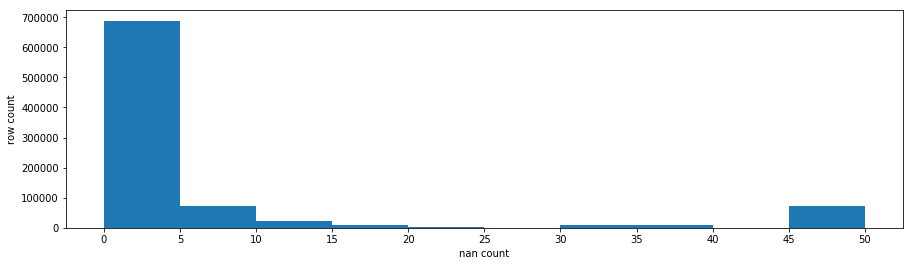

In [16]:
plt.figure(figsize=(15, 4))
plt.hist(nan_rowcount);
plt.xlabel("nan count")
plt.ylabel("row count")
plt.xticks(np.arange(0,55, 5)); # 50 is the max value, 55 for correct display

-> Data will be splitted into two groups with threeshold 25.


In [17]:
# Code to divide the data into two subsets based on the number of missing
# values in each row.
threeshold = 25
rows_many_missing = nan_rowcount[nan_rowcount > threeshold]
print ("Rows with nan count > {0}: \n\
count: {1} ({2:.2f}%)".format(threeshold, rows_many_missing.shape[0], (rows_many_missing.shape[0]/nan_rowcount.shape[0])*100))

Rows with nan count > 25: 
count: 93318 (10.47%)


There are 93318 rows with nan count > 25 which represents 10.47% of all rows.

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_distribution(column):
    fig = plt.figure(figsize=(15,4))
    fig.suptitle(column)

    sub1 = fig.add_subplot(121)
    sub1.title.set_text('Many missing rows')
    seaborn.countplot(azdias.loc[rows_many_missing.index,column])

    sub2 = fig.add_subplot(122)
    sub2.title.set_text('Few missing rows')
    seaborn.countplot(azdias.loc[~azdias.index.isin(rows_many_missing.index),column]);

    plt.show()

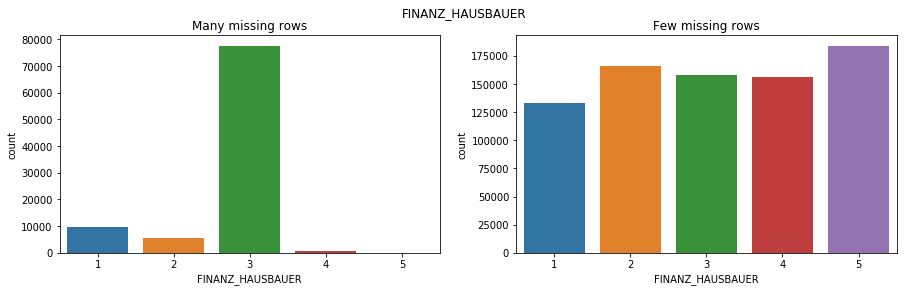

In [19]:
plot_distribution('FINANZ_HAUSBAUER')

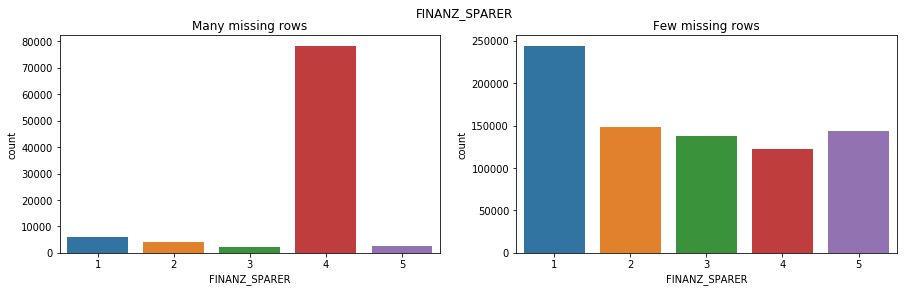

In [20]:
plot_distribution('FINANZ_SPARER')

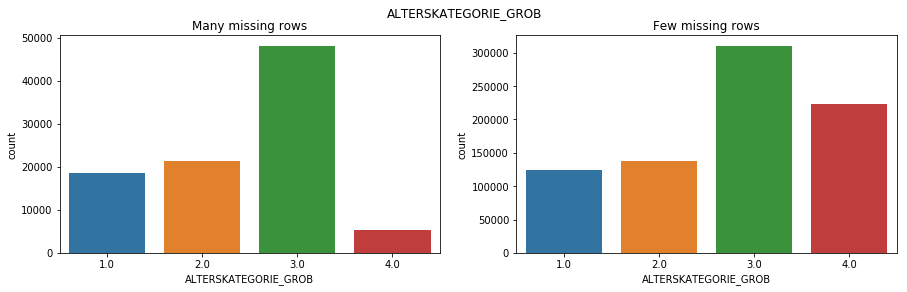

In [21]:
plot_distribution('ALTERSKATEGORIE_GROB')

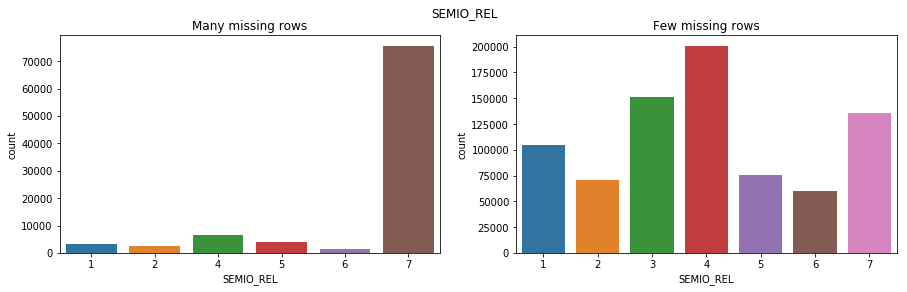

In [22]:
plot_distribution('SEMIO_REL')

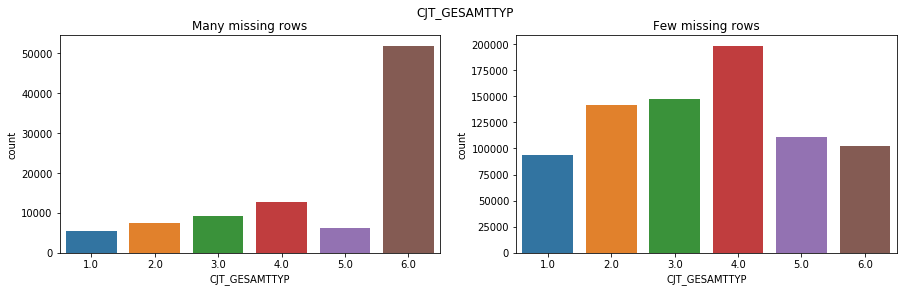

In [23]:
plot_distribution('CJT_GESAMTTYP')

In [24]:
# Save data with many missing rows for later analysis 
azdias_many_missing = azdias.iloc[rows_many_missing.index]

In [26]:
# Drop rows with many missing values

print('rows before removing empty ones: {0}'.format(azdias.shape[0]))
azdias = azdias[~azdias.index.isin(rows_many_missing.index)]
print('rows after removing empty ones: {0}'.format(azdias.shape[0]))

rows before removing empty ones: 891221
rows after removing empty ones: 797903


#### Discussion 1.1.3: Assess Missing Data in Each Row


There are 93318 rows (10.47% of all rows) with missing 26 or more values (out of 81*).
Data were splitted into rows with many missing values (more than 25) and with few ones (less or equal to 25).
To compare distribution between those two groups bar charts were created for 5 columns with few (less than 1%) missing values.
All tested columns `FINANZ_HAUSBAUER`, `FINANZ_SPARER`, `ALTERSKATEGORIE_GROB`, `SEMIO_REL`, `CJT_GESAMTTYP` shown different distribution between both categories. For this reason we will keep rows with missing values separately since removing them could introduce bias later.

*85 columns originall, 4 outliers removed = 81 remaining

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. We will check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, we make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, we perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether to keep, drop, or re-encode each. Then, in the last part, we create a new data frame with only the selected and engineered columns.

In [27]:
feat_info.head(3)

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]


In [28]:
# How many features are there of each data type?
feat_info["type"].value_counts()

ordinal        49
categorical    18
numeric         7
mixed           6
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, we perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. 

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
selection_columns = feat_info.loc[feat_info["type"] == "categorical", "attribute"].values

In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.
list_binary = []
list_multiple = []

for c in selection_columns:
    if azdias[c].nunique() > 2:
        list_multiple.append(c)
    else:
        list_binary.append(c)


In [31]:
#Let's analyze binary columns if any encoding is needed
for c in list_binary:
    print(azdias[c].value_counts())

2    416081
1    381822
Name: ANREDE_KZ, dtype: int64
0    622693
1    175210
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791187
1.0      6716
Name: SOHO_KZ, dtype: int64
2.0    394221
1.0    367022
Name: VERS_TYP, dtype: int64
W    629385
O    168518
Name: OST_WEST_KZ, dtype: int64


The output above shows that all columns needs encoding EXCEPT column `GREEN_AVANTGARDE`

In [32]:
#Encode binary columns
azdias["ANREDE_KZ"].replace([2, 1], [1, 0], inplace=True)
#azdias["GREEN_AVANTGARDE"].replace([1, 0], [1, 0], inplace=True) #no action needed, already right values
azdias["SOHO_KZ"].replace([1.0, 0.0], [1, 0], inplace=True) 
azdias["VERS_TYP"].replace([2.0, 1.0], [1, 0], inplace=True)
azdias["OST_WEST_KZ"].replace(["W", "O"], [1, 0], inplace=True)

In [33]:
# Check binary columns after encoding
for c in list_binary:
    print(azdias[c].value_counts())

1    416081
0    381822
Name: ANREDE_KZ, dtype: int64
0    622693
1    175210
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791187
1.0      6716
Name: SOHO_KZ, dtype: int64
1.0    394221
0.0    367022
Name: VERS_TYP, dtype: int64
1    629385
0    168518
Name: OST_WEST_KZ, dtype: int64


Next let's encode multi-level categorical variables. Since dataset is in pandas dataframe, let's use pandas.get_dummies

In [34]:
azdias = pd.get_dummies(azdias, columns=list_multiple)

#### Discussion 1.2.1: Re-Encode Categorical Features

Five categorical columns with binary values were found: `ANREDE_KZ`, `GREEN_AVANTGARDE`, `SOHO_KZ`, `VERS_TYP`, `OST_WEST_KZ`. Those binary categorical values were encoded into values of 0 and 1.

Next we encoded multi-level categorical columns. Since dataset is in pandas dataframe, straightforward pandas.get_dummies was used for encoding.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. We should break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
#Investigate PRAEGENDE_JUGENDJAHRE
print(azdias["PRAEGENDE_JUGENDJAHRE"].value_counts())

14.0    182965
8.0     141602
10.0     85797
5.0      84686
3.0      53840
15.0     42538
11.0     35747
9.0      33569
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [36]:
# Mapping between "PRAEGENDE_JUGENDJAHRE" value into generation and mainstream
generation_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}
mainstream = [1, 3, 5, 8, 10, 12, 14]

def get_generation(val_PRAEGENDE_JUGENDJAHRE):
    for key, array in generation_dict.items():
        if val_PRAEGENDE_JUGENDJAHRE in array:
            return key
    return np.nan
def get_mainstream(val_PRAEGENDE_JUGENDJAHRE):
    for i in mainstream:
        if i == val_PRAEGENDE_JUGENDJAHRE:
            return 1
    return 0

In [37]:
#Add into dataset variable for decade and movement

azdias['PRAEGENDE_JUGENDJAHRE_decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(get_generation)
azdias['PRAEGENDE_JUGENDJAHRE_movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(get_mainstream)

#Sanity check 
# - if anywhere in PRAEGENDE_JUGENDJAHRE_decade is nan, then error happened
print(azdias["PRAEGENDE_JUGENDJAHRE_decade"].value_counts())
print("\n")
print(azdias["PRAEGENDE_JUGENDJAHRE_movement"].value_counts())

5.0    225503
3.0    175171
4.0    151754
2.0    114348
1.0     74291
0.0     28157
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: int64


1    594014
0    203889
Name: PRAEGENDE_JUGENDJAHRE_movement, dtype: int64


In [38]:
# Investigate "CAMEO_INTL_2015"
print(azdias["CAMEO_INTL_2015"].value_counts())

51    133692
41     92336
24     91146
14     62878
43     56671
54     45389
25     39623
22     33149
23     26739
13     26334
45     26132
55     23954
52     20542
31     19018
34     18523
15     16974
44     14820
12     13245
35     10355
32     10354
33      9934
Name: CAMEO_INTL_2015, dtype: int64


In [39]:
# Mapping between "CAMEO_INTL_2015" value into wealth and lifestage
def get_wealth(val_CAMEO_INTL_2015):
    if pd.isnull(val_CAMEO_INTL_2015):
        return np.nan
    else:
        return int(str(val_CAMEO_INTL_2015)[0])

def get_lifestage(val_CAMEO_INTL_2015):
    if pd.isnull(val_CAMEO_INTL_2015):
        return np.nan
    else:
        return int(str(val_CAMEO_INTL_2015)[1])

In [40]:
azdias['CAMEO_INTL_2015_wealth'] = azdias['CAMEO_INTL_2015'].apply(get_wealth)
azdias['CAMEO_INTL_2015_lifestage'] = azdias['CAMEO_INTL_2015'].apply(get_lifestage)

#Sanity check 
# - if anywhere in CAMEO_INTL_2015_ is nan, then error happened
print(azdias["CAMEO_INTL_2015_wealth"].value_counts())
print("\n")
print(azdias["CAMEO_INTL_2015_lifestage"].value_counts())

5.0    223577
2.0    190657
4.0    189959
1.0    119431
3.0     68184
Name: CAMEO_INTL_2015_wealth, dtype: int64


1.0    245046
4.0    232756
3.0    119678
5.0    117038
2.0     77290
Name: CAMEO_INTL_2015_lifestage, dtype: int64


In [41]:
# Drop replaced columns
azdias.drop(["CAMEO_INTL_2015", "PRAEGENDE_JUGENDJAHRE"], axis=1, inplace=True)

In [42]:
#Investigate rest of mixed columns
feat_info["type"].value_counts()

mixed_columns = feat_info.loc[feat_info["type"] == "mixed"].values
print (mixed_columns)

[['LP_LEBENSPHASE_FEIN' 'person' 'mixed' '[0]']
 ['LP_LEBENSPHASE_GROB' 'person' 'mixed' '[0]']
 ['PRAEGENDE_JUGENDJAHRE' 'person' 'mixed' '[-1,0]']
 ['WOHNLAGE' 'building' 'mixed' '[-1]']
 ['CAMEO_INTL_2015' 'microcell_rr4' 'mixed' '[-1,XX]']
 ['PLZ8_BAUMAX' 'macrocell_plz8' 'mixed' '[-1,0]']]


In [43]:
# Drop redundant columns
azdias.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB"], axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Processing of `PRAEGENDE_JUGENDJAHRE`:
- Based on Data_Dictionary.md information about generation and movement (mainstream vs. avantgarde) were extracted into new columns `PRAEGENDE_JUGENDJAHRE_decade` and `PRAEGENDE_JUGENDJAHRE_mainstream`. Mainsterm is represented by 1, avantgarde by 0.

Processing of `CAMEO_INTL_2015`
- Information about wealth and lifestage were extracted into new columns `CAMEO_INTL_2015_wealth` and `CAMEO_INTL_2015_lifestage`

Since original columns CAMEO_INTL_2015 and `PRAEGENDE_JUGENDJAHRE` are not needed anymore, they were removed.

Remaining mixed columns are: `LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB`, `WOHNLAGE`, `PLZ8_BAUMAX`
- `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` were removed since it contains info already extracted above - wealth, age, lifestage. The rest I consider as categorical values and use as they are.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that our data frame now only has the columns that we want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

We need to make sure that for any new columns that we have engineered, that we have excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, we should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features we created should be retained. 

In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
np.unique(azdias.dtypes.values) # Sanity check of data type

array([dtype('uint8'), dtype('int64'), dtype('float64')], dtype=object)

### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. For this substep, we completed the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, we can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
def clean_data(data_frame):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    df = data_frame.copy()
    # convert missing value codes into NaNs, ...
    for column in df.columns:
        df[column] = df[column].replace(missing_vals.loc[column][0], np.nan) 
    
    # remove selected columns and rows, ...
    drop_columns = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(drop_columns, axis=1, inplace=True)
    
    # split between rows with many missing values
    nan_rowcount = df.isnull().sum(axis=1)
    rows_many_missing = nan_rowcount[nan_rowcount > 25]
    df_many_missing = df.iloc[rows_many_missing.index]
    df = df[~df.index.isin(rows_many_missing.index)]    
    
    #Encode binary columns
    df["ANREDE_KZ"].replace([2, 1], [1, 0], inplace=True)
    #azdias["GREEN_AVANTGARDE"].replace([1, 0], [1, 0], inplace=True) #no action needed, already right values
    df["SOHO_KZ"].replace([1.0, 0.0], [1, 0], inplace=True) 
    df["VERS_TYP"].replace([2.0, 1.0], [1, 0], inplace=True)
    df["OST_WEST_KZ"].replace(["W", "O"], [1, 0], inplace=True)
    
    # select, re-encode, and engineer column values.
    df = pd.get_dummies(df, columns=list_multiple)
    
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_generation)
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_mainstream)
    
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(get_wealth)
    df['CAMEO_INTL_2015_lifestage'] = df['CAMEO_INTL_2015'].apply(get_lifestage)
    
    df.drop(["CAMEO_INTL_2015", "PRAEGENDE_JUGENDJAHRE"], axis=1, inplace=True)
    
    #drop redundant mixed columns
    df.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB"], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df, df_many_missing

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, we'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help us navigate to all of the classes and functions that we will need. In this substep, we need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, we need to make sure that we have cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. 
- For these classes, we will make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. 

In [46]:
# clean the dataset of all NaN values
features = azdias.copy()

imputer = Imputer(strategy="median")
imputed_features = imputer.fit_transform(features)

In [47]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
standardized_features = scaler.fit_transform(imputed_features)

### Discussion 2.1: Apply Feature Scaling

Imputer was used to solve missing (nan) values so it's compatible with sklear estimators. Median was used instead of mean to be more robust against outliers.

### Step 2.2: Perform Dimensionality Reduction

On our scaled data, we are now ready to apply dimensionality reduction techniques.

- We will use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we will not set any parameters (so all components are computed).
- We will check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Plotting  ofthe cumulative or sequential values is done using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what we find, we will select a value for the number of transformed features we will retain for the clustering part of the project.
- Once we have made a choice for the number of components to keep, we will re-fit a PCA instance to perform the decided-on transformation.

In [48]:
# Apply PCA to the data.
pca = PCA()
pca_features = pca.fit_transform(standardized_features)

In [49]:
# Investigate the variance accounted for by each principal component.
def plot_variance(pca, title):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    ''' 
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
        
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance (%)');
    plt.title(title)

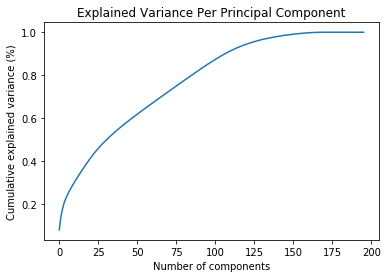

In [50]:
plot_variance(pca, "Explained Variance Per Principal Component")

In [51]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(97)
pca_features = pca.fit_transform(standardized_features)

pre-transformation shape:    (797903, 196)
after-transformation shape: (797903, 97)


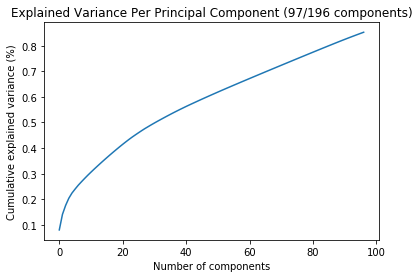

In [52]:
print("pre-transformation shape:   ", features.shape)
print("after-transformation shape:", pca_features.shape)

plot_variance(pca, "Explained Variance Per Principal Component (97/196 components)")

### Discussion 2.2: Perform Dimensionality Reduction

Principal component analysis (PCA) showed, that reducing components to 97 (originally 196, thus over 50% reduction) would still retain information about more than 85% of variance. So for next step we retain 97 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Dictionary document was used to help with understandrding these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- We will investigate and interpret feature associations from the first three principal components in this substep.

In [53]:
def plot_pca(data, pca, n_compo):
    '''
	Plot the features with the most absolute variance for given pca component 
	'''
    compo = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[n_compo-1]
    compo.sort_values(ascending=False, inplace=True)
    compo = pd.concat([compo.head(3), compo.tail(3)])
    
    compo.plot(kind='bar', title='Component ' + str(n_compo))
    p = plt.gca()
    p.grid(linewidth='0.33')
    p.set_axisbelow(True)
    plt.show()

For the first 3 principal components:

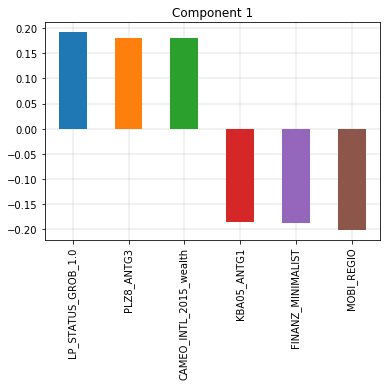

In [54]:
# 1. principal component
plot_pca(azdias, pca, 1)

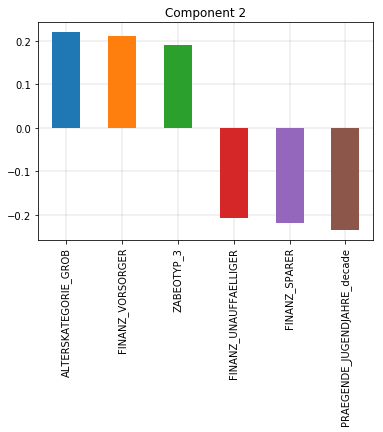

In [55]:
# 2. principal component
plot_pca(azdias, pca, 2)

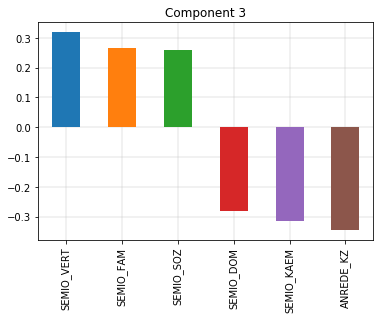

In [56]:
# 3. principal component
plot_pca(azdias, pca, 3)

### Discussion 2.3: Interpret Principal Components

The first principal component has positive association with:
- `LP_STATUS_GROS.` Social status (higher means higher status/income)
- `PLZ8_ANTG3` Number of 6-10 family houses in the PLZ8 reg (higher means higher share)
- `CAMEO_INTL_2015_WEALTH` Wealth Level of person's household (higher means lower wealth)

The first principal component has negative association with:
- `MOBI_REGIO` Movement patterns (higher means lower movement)
- `FINANZ_MINIMALIST` Financial typology, low financial interrest (higher is lower)
- `KBA05_ANTG1` Number of 1-2 family houses

-> The first component seems to be related to one individual financial status and number of 6-10 family houses in the region. At the same time with low level of personal wealth and low financial interrest. Could represent category of high-spenders.

The second principal component has positive association with:
- `ALTERSKATEGORIE_GROS` Estimated age (higher means older)
- `FINANZ_VORSORGER` Financial typology, be prepared (higher means lower)
- `SEMIO_ERL` Personality typology, event oriented (higher means lower affinity)

The second principal component has negative association with:
- `FINANZ_UNAUFFAELLIGER` Financial typology, inconspicuous (higher means lower)
- `FINANZ_SPARER` Financial typology, money-saver (higher means lower)
- `PRAEGENDE_JUDENDJAHRE_DECADE` Decade of person youths (higher means higher decade)

-> The second component seems to be positively related to one age and financial habits. The second component could represent people who accumulated wealth since it prefers higher age and money-savers.

The third principal component has positive association with:
- `SEMIO_VERT` Personality typology, dreamful (higher means lower affinity)
- `SEMIO_KULT` Personality typology, cultural-minded (higher means lower affinity)
- `SEMIO_SOZ` Personality typology, socially-minded (higher means lower affinity)

The third principal component has negative association with:
- `ANREDE_KZ` Gender (1 means man, 2 means female)
- `SEMIO_KRIT` Personality typology, critical-minded (higher means lower affinity)
- `SEMIO_KAEM` Personality typology, combative-attitude (higher means lower affinity)

-> The third component seems to be related to personality traits and gender. It separetes dominant males and family-oriented femals.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We have assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- We will use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. 
- Perform the above two steps for a number of different cluster counts. We can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. We will use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. We should test for cluster counts through at least 10 clusters to get the full picture, but we shouldn't need to test for a number of clusters above about 30.
- Once we have selected a final number of clusters to use, we will re-fit a KMeans instance to perform the clustering operation. 

In [57]:
def plot_cluster_distance(k_range, sse):
    plt.plot(k_range, sse, marker='o');
    plt.xlabel('k');
    plt.ylabel('SSE');
    plt.title('SSE(k)');

In [58]:
#Select only sample of 33% data for faster k-values exploration
pca_features_sample = pca_features[np.random.choice(pca_features.shape[0], \
                                                    int(pca_features.shape[0]*0.33), replace=False)]

In [59]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.    
start_time = time.time()

sse = []
k_range = np.arange(12, 20, 2)

for k in k_range:
    kmeans = KMeans(k).fit(pca_features_sample)
    sse.append(np.abs(kmeans.score(pca_features_sample)))

print("--- Run time: {0} mins ---".format(np.round(((time.time() - start_time)/60),2)))

--- Run time: 9.93 mins ---


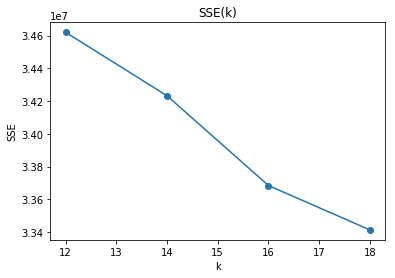

In [60]:
plot_cluster_distance(k_range, sse)

In [61]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
start_time = time.time()

sse = []
k_range = np.arange(20, 28, 2)

for k in k_range:
    kmeans = KMeans(k).fit(pca_features_sample)
    sse.append(np.abs(kmeans.score(pca_features_sample)))

print("--- Run time: {0} mins ---".format(np.round(((time.time() - start_time)/60),2)))

--- Run time: 14.53 mins ---


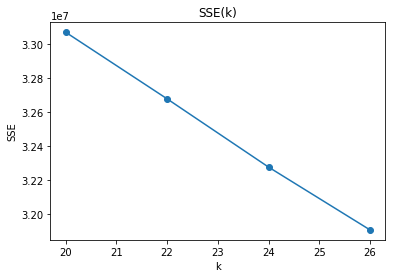

In [62]:
plot_cluster_distance(k_range, sse)

Not clear elbow is visible, so 26 will be used.

In [63]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
start_time = time.time()

kmeans = KMeans(26).fit(pca_features)

kmeans_labels = kmeans.predict(pca_features)

print("--- Run time: {0} mins ---".format(np.round(((time.time() - start_time)/60),2)))

--- Run time: 11.19 mins ---


### Discussion 3.1: Apply Clustering to General Population

To reduce computing time sample 33% of the features data was used. 
With this sample kmeans models 12-28 were calculated. To futher reduce time, kmeans were calculated with step 2.
There was no visible elbow, so the value 26 was chosen to be number of clusters for the whole dataset.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

#Check that data were properly loaded
if customers.shape[1] == 85:
    print("Success: customers file loaded correctly")
else:
    print("Warrning: Count of columns does no corresponds expected value")

Success: customers file loaded correctly


In [66]:
print(customers.shape[0])
customers.tail(3)

191652


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
191649,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3,3,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0
191651,3,2,1,2.0,5,1,5,1,1,2,...,3.0,2.0,0.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0


In [67]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
features_customers, customers_many_missing  = clean_data(customers)

In [68]:
#Compare columns in general population dataset with customer dataset
list(set(azdias.columns) - set(features_customers))

['GEBAEUDETYP_5.0']

Output above shows that in customers dataset is missing column GEBAEUDETYP_5.0. It seems that in customers dataset is not row with value GEBAEUDETYP=5.0.  We need to add this value to customers dataset and pass it through clean_data again, so features are consistent between the general and the customers population.

In [69]:
customers_fix = customers.copy()
customers_fix = pd.concat([customers_fix, customers_fix.iloc[-1:]], ignore_index=True)
customers_fix.loc[191652,'GEBAEUDETYP'] = 5.0
features_customers, customers_many_missing  = clean_data(customers_fix)

In [70]:
features_customers.tail(3) #Sanity check - 196 columns should exists now

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
191650,3.0,1,2,1,5,1,2,5,NaN,0,...,0,0,0,0,0,0,3.0,1,2.0,4.0
191651,2.0,0,5,1,5,1,1,2,1937.0,0,...,0,0,0,0,0,0,1.0,1,3.0,3.0
191652,2.0,0,5,1,5,1,1,2,1937.0,0,...,0,0,0,0,0,0,1.0,1,3.0,3.0


In [71]:
features_customers.drop([191652], inplace=True)
features_customers.tail(3) #sanity check - last row 191651 expected as before

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
191649,4.0,0,5,1,5,1,1,2,1944.0,1,...,0,0,0,0,0,0,1.0,0,2.0,4.0
191650,3.0,1,2,1,5,1,2,5,NaN,0,...,0,0,0,0,0,0,3.0,1,2.0,4.0
191651,2.0,0,5,1,5,1,1,2,1937.0,0,...,0,0,0,0,0,0,1.0,1,3.0,3.0


In [72]:
features.tail(3) #Sanity check if number of columns in features(azdias) is equal \
                    #to number of columns in features_customers

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
891218,2.0,1,2,4,2,5,4,3,1976.0,0,...,0,0,0,0,0,0,5.0,1,2.0,4.0
891219,1.0,0,1,5,3,5,5,5,1994.0,0,...,0,0,0,0,1,0,5.0,1,5.0,1.0
891220,4.0,0,4,2,5,2,1,5,NaN,0,...,0,0,0,0,0,0,1.0,1,4.0,3.0


In [73]:
#Sanity check - Compare columns in general population dataset with customer dataset - should equal
list(set(azdias.columns) - set(features_customers))

[]

In [74]:
imputed_customers = imputer.transform(features_customers)
standardized_customers = scaler.transform(imputed_customers)
pca_customers = pca.transform(standardized_customers)
kmeans_customers = kmeans.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

We will take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where we separated out certain data points from the dataset if they had more than a specified threshold of missing values. 
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? We will one such cluster and infer what kind of people might be represented by that cluster. We will use the principal component interpretations from step 2.3. 
- We will perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [75]:
# Account for rows with many missing values
azdias_many_missing_array = np.full((azdias_many_missing.shape[0],), -1)
kmeans_all_labels = np.concatenate([kmeans_labels, azdias_many_missing_array])

customers_many_missing_array = np.full((customers_many_missing.shape[0],), -1)
kmeans_all_customers = np.concatenate([kmeans_customers, customers_many_missing_array])

In [76]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Proportions for general data
dict_data = {"Proportion": pd.Series(kmeans_all_labels).value_counts(normalize=True, sort=False), 
          "source": "general"}

general_proportions = pd.DataFrame(dict_data)

# Proportions for customer data
dict_data = {"Proportion": pd.Series(kmeans_all_customers).value_counts(normalize=True, sort=False), 
          "source": "customer"}

customer_proportions = pd.DataFrame(dict_data)

# Concatenate proportions
total_proportions = pd.concat([general_proportions, customer_proportions])


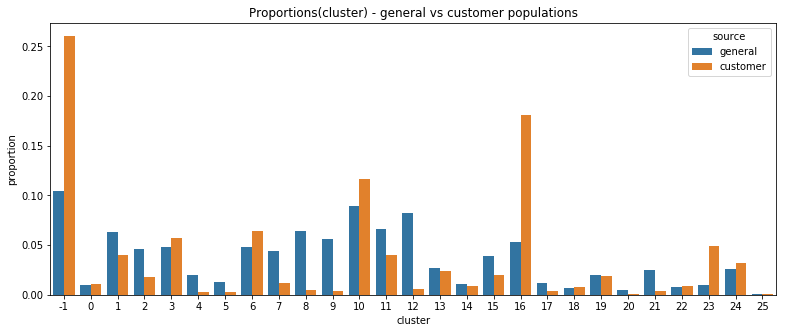

In [71]:
fig, ax = plt.subplots(figsize=(13,5))
seaborn.barplot(ax=ax, x=total_proportions.index, y = total_proportions.proportion, hue=total_proportions.source)
ax.set_xlabel("Cluster")
ax.set_title("Proportions(cluster) - general vs customer populations");

In [79]:
# Check difference in cluster proportion for general vs customer populations
diff_customer_proportions = customer_proportions["Proportion"] - general_proportions["Proportion"]
diff_customer_proportions.sort_values(ascending=False, inplace=True)
print("over-represented")
print(diff_customer_proportions[:3])
print("\n")
print("under-represented")
print(diff_customer_proportions[-3:])

over-represented
-1     0.155905
 8     0.111912
 17    0.043593
Name: Proportion, dtype: float64


under-represented
13   -0.051031
3    -0.051502
24   -0.053061
Name: Proportion, dtype: float64


In [80]:
def plot_cluster_demographics(k, pca_features, kmeans_labels):
    pca_cluster = pca_features[kmeans_labels == k]

    print("cluster {0} represents {1}% of population".format(k, np.round(pca_cluster.shape[0]*100/features.shape[0],3)), "")

    standardized_features = pca.inverse_transform(pca_cluster)
    features_cluster = scaler.inverse_transform(standardized_features)

    features_cluster = pd.DataFrame(np.round(features_cluster), columns = azdias.columns)

    fig, axs = plt.subplots(2,3, figsize=(18,8))
    seaborn.countplot(features_cluster["CAMEO_INTL_2015_wealth"], ax = axs[0,0], color="c")
    seaborn.countplot(features_cluster["ALTERSKATEGORIE_GROB"], ax = axs[0,1], color="c")
    seaborn.countplot(features_cluster["FINANZ_SPARER"], ax = axs[0,2], color="c")
    seaborn.countplot(features_cluster["ANREDE_KZ"], ax = axs[1,0], color="c")
    seaborn.countplot(features_cluster["SEMIO_KAEM"], ax = axs[1,1], color="c")
    seaborn.countplot(features_cluster["MOBI_REGIO"], ax = axs[1,2], color="c")
    plt.show();

cluster 16 represents 9.869% of population 


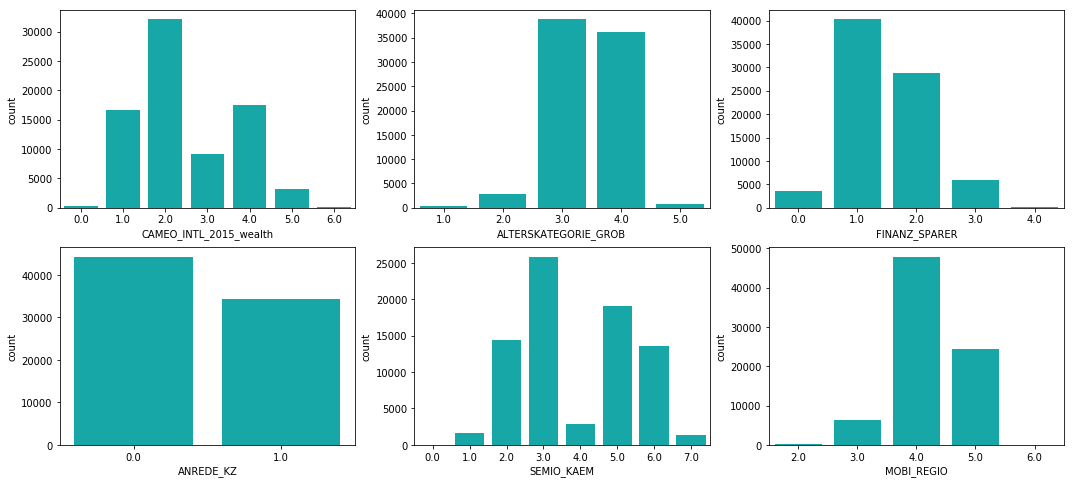

In [81]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

plot_cluster_demographics(k=16, pca_features=pca_features, kmeans_labels=kmeans_labels)

cluster 12 represents 3.651% of population 


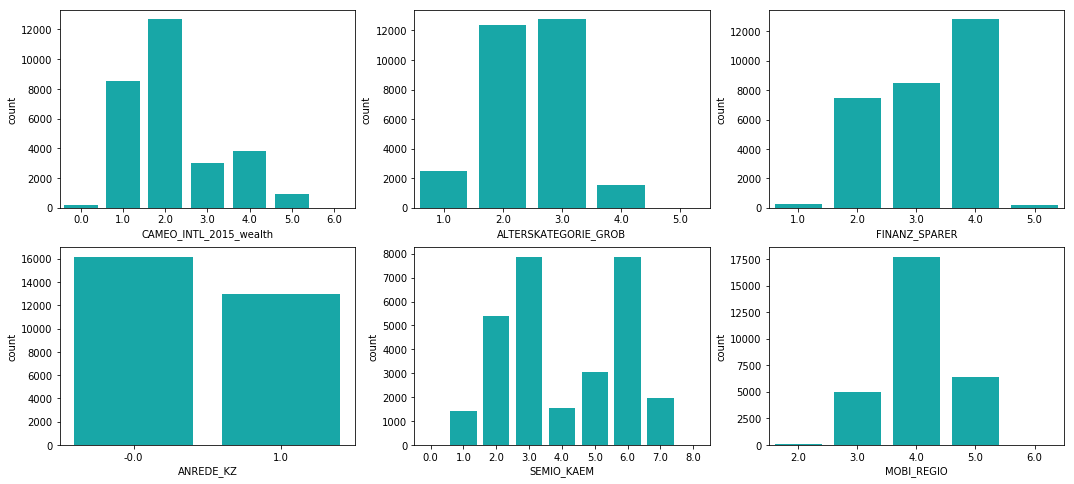

In [82]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
plot_cluster_demographics(k=12, pca_features=pca_features, kmeans_labels=kmeans_labels)

### Discussion 3.3: Compare Customer Data to Demographics Data

After comparing populations that were customers with population that were not evaluating categories like wealth, age, financial habits, gender, personality typology (dominance affinity) and movement patterns:

- The popular cluster is made of persons with high wealth, age 46 and more, with good financial habits (money-savers), males, dominant, low movement.

- The unpopular cluster is made of persons from poorer households,  younger age (0-45 years), without money-savings habits, mostly females, not-dominant, high movement.